This notebook presents a brief exploration of the files that come with the dataset. The objective is notebook is to:
- Prepare the `.csv` files from the `.xml` annotations so that the `xml_to_csv.py` can be executed to generate the `.csv` files. These files are needed to generate `TFRecords`. 
- Explore the distribution of the classes present in the dataset. There are essentially three classes: RBC, WBC and Platelets. 
- Manual inspection of the annotations provided. 
- Some additional notes regarding running the `generate_tfrecord.py` script. 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shutil
import cv2
import os

In [2]:
!ls BCCD/

Annotations  ImageSets	JPEGImages


This is a PASCAL-VOC style dataset. We are in luck!

In [3]:
train_df = pd.read_csv("BCCD/ImageSets/Main/train.txt", sep = " ", header=None)
val_df = pd.read_csv("BCCD/ImageSets/Main/val.txt", sep = " ", header=None)

In [4]:
train_df.head()

,0
0,BloodImage_00001
1,BloodImage_00003
2,BloodImage_00004
3,BloodImage_00005
4,BloodImage_00006


In [5]:
val_df.head()

,0
0,BloodImage_00000
1,BloodImage_00002
2,BloodImage_00014
3,BloodImage_00017
4,BloodImage_00028


In [6]:
images_path = os.listdir("BCCD/JPEGImages/")
len(images_path)

364

This includes the test images as well which we will not be including during training our custom object detection model. 

In [7]:
def show_images():
    plt.figure(figsize=(15,15))
    for i in range(10):
        n = np.random.choice(364, 1)
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(True)
        image = plt.imread(os.path.join("BCCD/JPEGImages/", images_path[int(n)]))
        plt.imshow(image)
    plt.show()

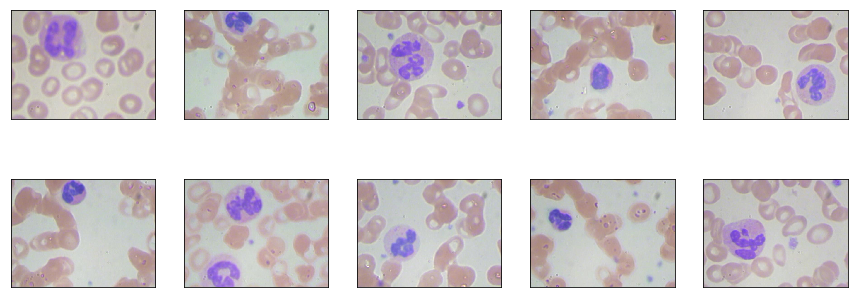

In [8]:
show_images()

In [23]:
# Total number of train and validation images
len(train_df[0].tolist()), len(val_df[0].tolist())

(205, 87)

We now need to separate out the train and validation images from the given dataset. We will create another directory called `images` and under that we will maintain `train` and `test` directories to store the images accordingly. For this project, we will be creating them manually but this process can easily be automated. [This PyImageSearch blog](https://www.pyimagesearch.com/2019/06/03/fine-tuning-with-keras-and-deep-learning/) gives a nice overview of that. 

In [16]:
# Training images & their annotations
for path in train_df[0].tolist():
    image_path = os.path.join("BCCD/JPEGImages/", path + ".jpg")
    annotation_path = os.path.join("BCCD/Annotations/", path + ".xml")
    i_path = os.path.join("images/train", path + ".jpg")
    a_path = os.path.join("images/train", path + ".xml")
    shutil.copy2(image_path, i_path)
    shutil.copy2(annotation_path, a_path)

In [17]:
# Validation images & their annotations
for path in val_df[0].tolist():
    image_path = os.path.join("BCCD/JPEGImages/", path + ".jpg")
    annotation_path = os.path.join("BCCD/Annotations/", path + ".xml")
    i_path = os.path.join("images/test", path + ".jpg")
    a_path = os.path.join("images/test", path + ".xml")
    shutil.copy2(image_path, i_path)
    shutil.copy2(annotation_path, a_path)

In [18]:
len(os.listdir("images/train")), len(os.listdir("images/test"))

(410, 174)

In [46]:
# copy the annotation files of the training images
for path in train_df[0].tolist():
    image_path = os.path.join("BCCD/Annotations/", path + ".xml")
    p = os.path.join("images/train", path + ".xml")
    shutil.copy2(image_path, p)

In [47]:
# copy the annotation files of the validation images
for path in val_df[0].tolist():
    path = path.split(".")[0] + ".xml"
    image_path = os.path.join("BCCD/Annotations/", path)
    p = os.path.join("images/test", path + ".xml")
    shutil.copy2(image_path, p)

Now that we have separated the training images from the validation images along with their annotations, we can go ahead and run `xml_to_csv.py`. After running the `xml_to_csv.py` script, we will have `train_labels.csv` and `test_labels.csv` files. Let's load them up. 

In [24]:
train_labels = pd.read_csv("train_labels.csv")
test_labels = pd.read_csv("test_labels.csv")

In [25]:
train_labels["class"].value_counts()

RBC          2382
WBC           214
Platelets     209
Name: class, dtype: int64

In [26]:
test_labels["class"].value_counts()

RBC          968
WBC           87
Platelets     83
Name: class, dtype: int64

We need to modify the `generate_tfrecord.py` file accordingly specifying the encodings for **RBC**, **WBC** and **Platelets**. Now, let's visually inspect the annotations with the help of OpenCV.

**Note**: We are lucky that the labels matched in both the sets but in reality this may not be the case. So, the idea will be to discard the classes from the test/validation set that are not present in the training set. 

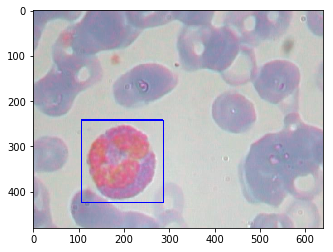

In [27]:
image_1 = cv2.imread('images/train/BloodImage_00036.jpg')
image_1 = cv2.cvtColor(image_1,cv2.COLOR_BGR2RGB)
cv2.rectangle(image_1, (107, 242), (287, 423), (255,0,0), 2)
cv2.imwrite('rectangle.png', image_1)

image = plt.imread('rectangle.png')
plt.imshow(image)
plt.show()

### Note when running `generate_tfrecord.py` script

While running the script please pay attention to line number 90 `path = os.path.join(os.getcwd(), 'images/test')` and assign the path accordingly with respect to the kind of the split (train/test) you running the script for. 